In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import sweetviz
import pandas_profiling

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
# figure size in inches
rcParams['figure.figsize'] = 8, 4

sns.set(font_scale=1.5)
# pd.set_option('display.max_rows', None)

from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# Load csv files as data frames.
path = '../data/all-data/'
df1 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv(f'{path}Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv(f'{path}Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv(f'{path}Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv(f'{path}Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv(f'{path}Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv(f'{path}Wednesday-workingHours.pcap_ISCX.csv')

#### Data Cleaning

In [5]:
# This part could be used in data cleaning V.2.
# Drop low count "Destination Port" from the 4th data frame (Benign activities data frame).
high_count_benign_ports = df4[' Destination Port'].value_counts()[:20].index
df4 = df4[df4[' Destination Port'].isin(high_count_benign_ports)]
df4.reset_index(drop=True, inplace=True)

In [3]:
# Remove etries labled "BENIGN" from all dataframes except the 4th data frame.
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
for i, df in enumerate(dfs):
    if i != 3:
        dfs[i] = dfs[i][dfs[i][' Label'] != 'BENIGN']

# Concatenate all data frames.
final_df = pd.concat(dfs)

# Print shape of the final data frame before updates.
print('Data frame shape before updates...')
print(final_df.shape, end='\n\n')

Data frame shape before updates...
(1087564, 79)



In [4]:
final_df.sample(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
119168,443,252188,13,8,1203,4254,725,0,92.538462,204.741551,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
260543,80,98188833,7,5,371,11595,365,0,53.000000,137.597238,...,20,1989.0,0.0,1989,1989,98200000.0,0.0,98200000,98200000,DoS Hulk
345711,53,418387,4,4,176,240,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
200439,80,1,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
66357,80,25108,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS


In [5]:
final_df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [25]:
# Remove extra spaces from feature names.
cols = final_df.columns.str.strip()
final_df.columns = cols

# Convert labels to lower case and replace column names spaces with "_".
cols = []
for i, col in enumerate(final_df.columns):
    new_col_name = col.lower()
    new_col_name = '_'.join(new_col_name.split())
    cols.append(new_col_name)
final_df.columns = cols

# Add new feature "is_intrusion" and make it's value for each entry 0.
final_df['is_intrusion'] = 0

# Chnage "is_intrusion" values for entries that are not labeled "benign" to 1.
final_df.loc[final_df['label'] != 'BENIGN', 'is_intrusion'] = 1

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(928391, 70)


In [7]:
# Drop columns that have the same value for all entries.
for i, col in enumerate(final_df.columns[:-2]):
    if (final_df[col] == final_df[col][0]).all():
        final_df = final_df.drop(columns=[col]) 

# Reset final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(1087564, 70)


In [8]:
# Print target classes
final_df.label.value_counts()

BENIGN                        529918
DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: label, dtype: int64

In [9]:
# Transform "labele" values to lower case.
final_df.label = final_df.label.str.lower()

# Group similar attacks.
final_df.loc[final_df['label'].str.startswith('dos'), 'label'] = 'dos'
final_df.loc[final_df['label'].str.startswith('web'), 'label'] = 'web_attack'
final_df.loc[final_df['label'].str.endswith('patator'), 'label'] = 'brute_force'

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(1087564, 70)


In [10]:
# This part could be used in data cleaning V.2.
# Drop entires that have Labels with low count (<100).
labeles_to_drop = final_df.label.value_counts()[-2:].index
final_df.drop(final_df.index[final_df['label'].isin(labeles_to_drop)], inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(1087517, 70)


In [10]:
# Check for Null values.
print('How many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Replace Inf values with NaN.
final_df = final_df.replace([np.inf, -np.inf], np.nan)

# Drop all occurences of NaN.
print('Removing Null values...')
final_df = final_df.dropna()

# Rest final data frame indexes.      
final_df.reset_index(drop=True, inplace=True)

# Double check these are all gone.
print('\nHow many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many Null values are there?
1013

Removing Null values...

How many Null values are there?
0

Data frame shape after updates...
(1086037, 70)


In [11]:
# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Drop duplicated entries.
print('Droping duplicated entries...', end='\n\n')
final_df.drop_duplicates(inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many duplicated entries are there?
157646

Droping duplicated entries...

How many duplicated entries are there?
0

Data frame shape after updates...
(928391, 70)


In [12]:
final_df.sample(2)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,is_intrusion
310686,80,8084746,4,2,0,212,0,0,0.0,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,benign,0
36023,80,78389489,8,5,56,11601,20,0,7.0,5.656854,...,1957103.0,0.0,1957103,1957103,75400000.0,0.0,75400000,75400000,ddos,1


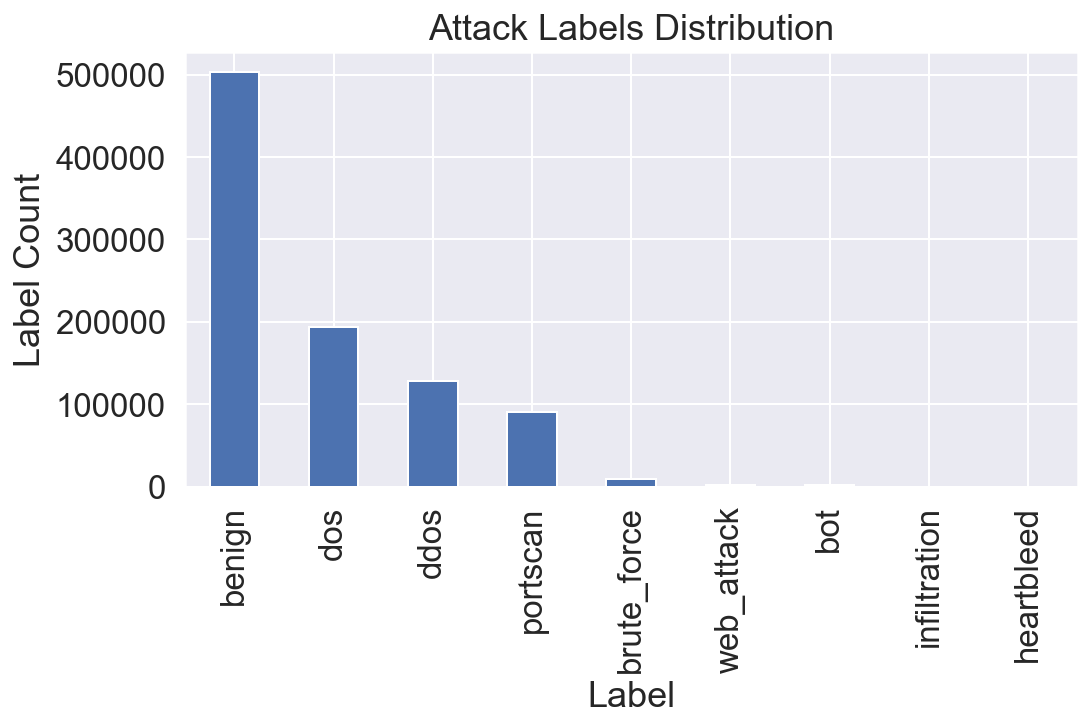

In [15]:
# Plot Attck Label distibution.
final_df.label.value_counts().plot.bar()
plt.title('Attack Labels Distribution')
plt.xlabel('Label')
plt.ylabel('Label Count')
plt.show()

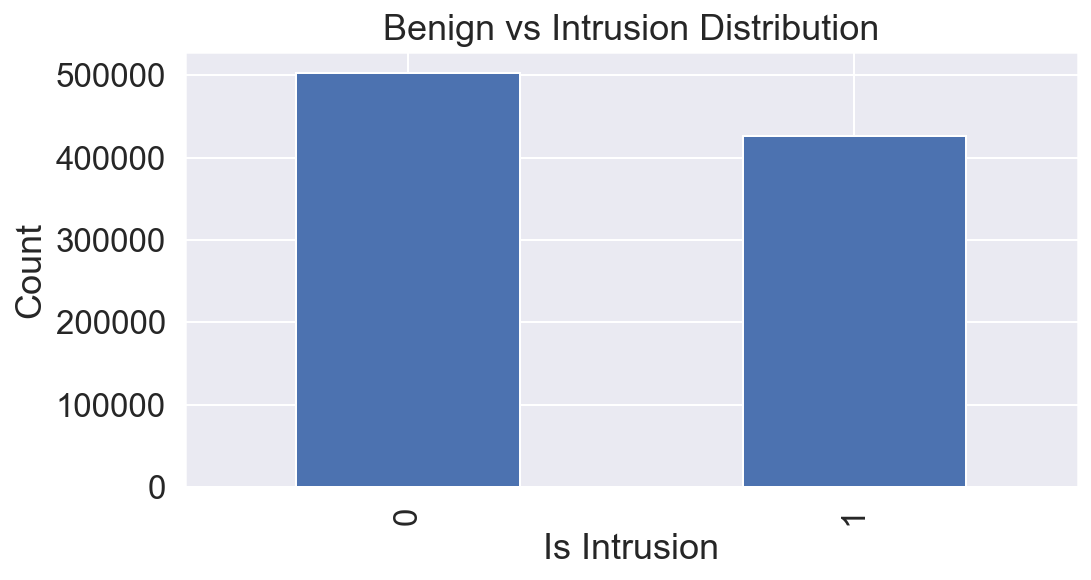

In [20]:
# Plot "is_intrusion" distibution.
final_df.is_intrusion.value_counts().plot.bar()
plt.title('Benign vs Intrusion Distribution')
plt.xlabel('Is Intrusion')
plt.ylabel('Count')
plt.show()

In [14]:
# Save the final data frame to a csv file. 
final_df.to_csv(f'{path}intrusion_detection_data_v1.csv', index=False)

In [25]:
df.sample(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,is_intrusion
624429,22,11529850,21,32,2008,2745,640,0,95.619048,140.045163,...,0.0,0.0,0,0,0.0,0.0,0,0,brute_force,1
268080,443,117577,11,6,673,1588,437,0,61.181818,131.760251,...,0.0,0.0,0,0,0.0,0.0,0,0,benign,0
729739,80,85744616,6,7,368,11595,356,0,61.333333,144.386518,...,11017.0,0.0,11017,11017,84700000.0,0.0,84700000,84700000,dos,1
74807,80,803495,3,6,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,ddos,1
685884,80,85058097,8,6,323,11595,323,0,40.375000,114.197745,...,966.0,0.0,966,966,84900000.0,0.0,84900000,84900000,dos,1


#### Auto EDA

In [46]:
# Sweetviz auto EDA.
report  = sweetviz.analyze(final_df)
report.show_html('../auto_EDA_report.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:07 -> (00:00 left)


Report ../auto_EDA_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Feature Selection (Chi-squared test)

In [36]:
# Find features with negative values to be excluded from the Chi-squared test.
neg_col = []
for col in final_df.columns[:-2]:
    if (final_df[col] < 0).any():
        neg_col.append(col)
neg_col

['flow_duration',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_min',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_header_length.1',
 'init_win_bytes_forward',
 'init_win_bytes_backward',
 'min_seg_size_forward']

In [37]:
X = final_df.drop(columns=['label', 'is_intrusion']+neg_col, axis=1)
y = final_df['label']

In [38]:
chi2_sortedlist = chi2(X, y)

In [39]:
# Restructure the Chi-squared results in a dictionary.
chi2_sortedlist = dict(zip(X.columns, chi2_sortedlist[0]))

# Sort the Chi-squared results.
chi2_sortedlist = dict(sorted(chi2_sortedlist.items(), key=lambda item: item[1]))

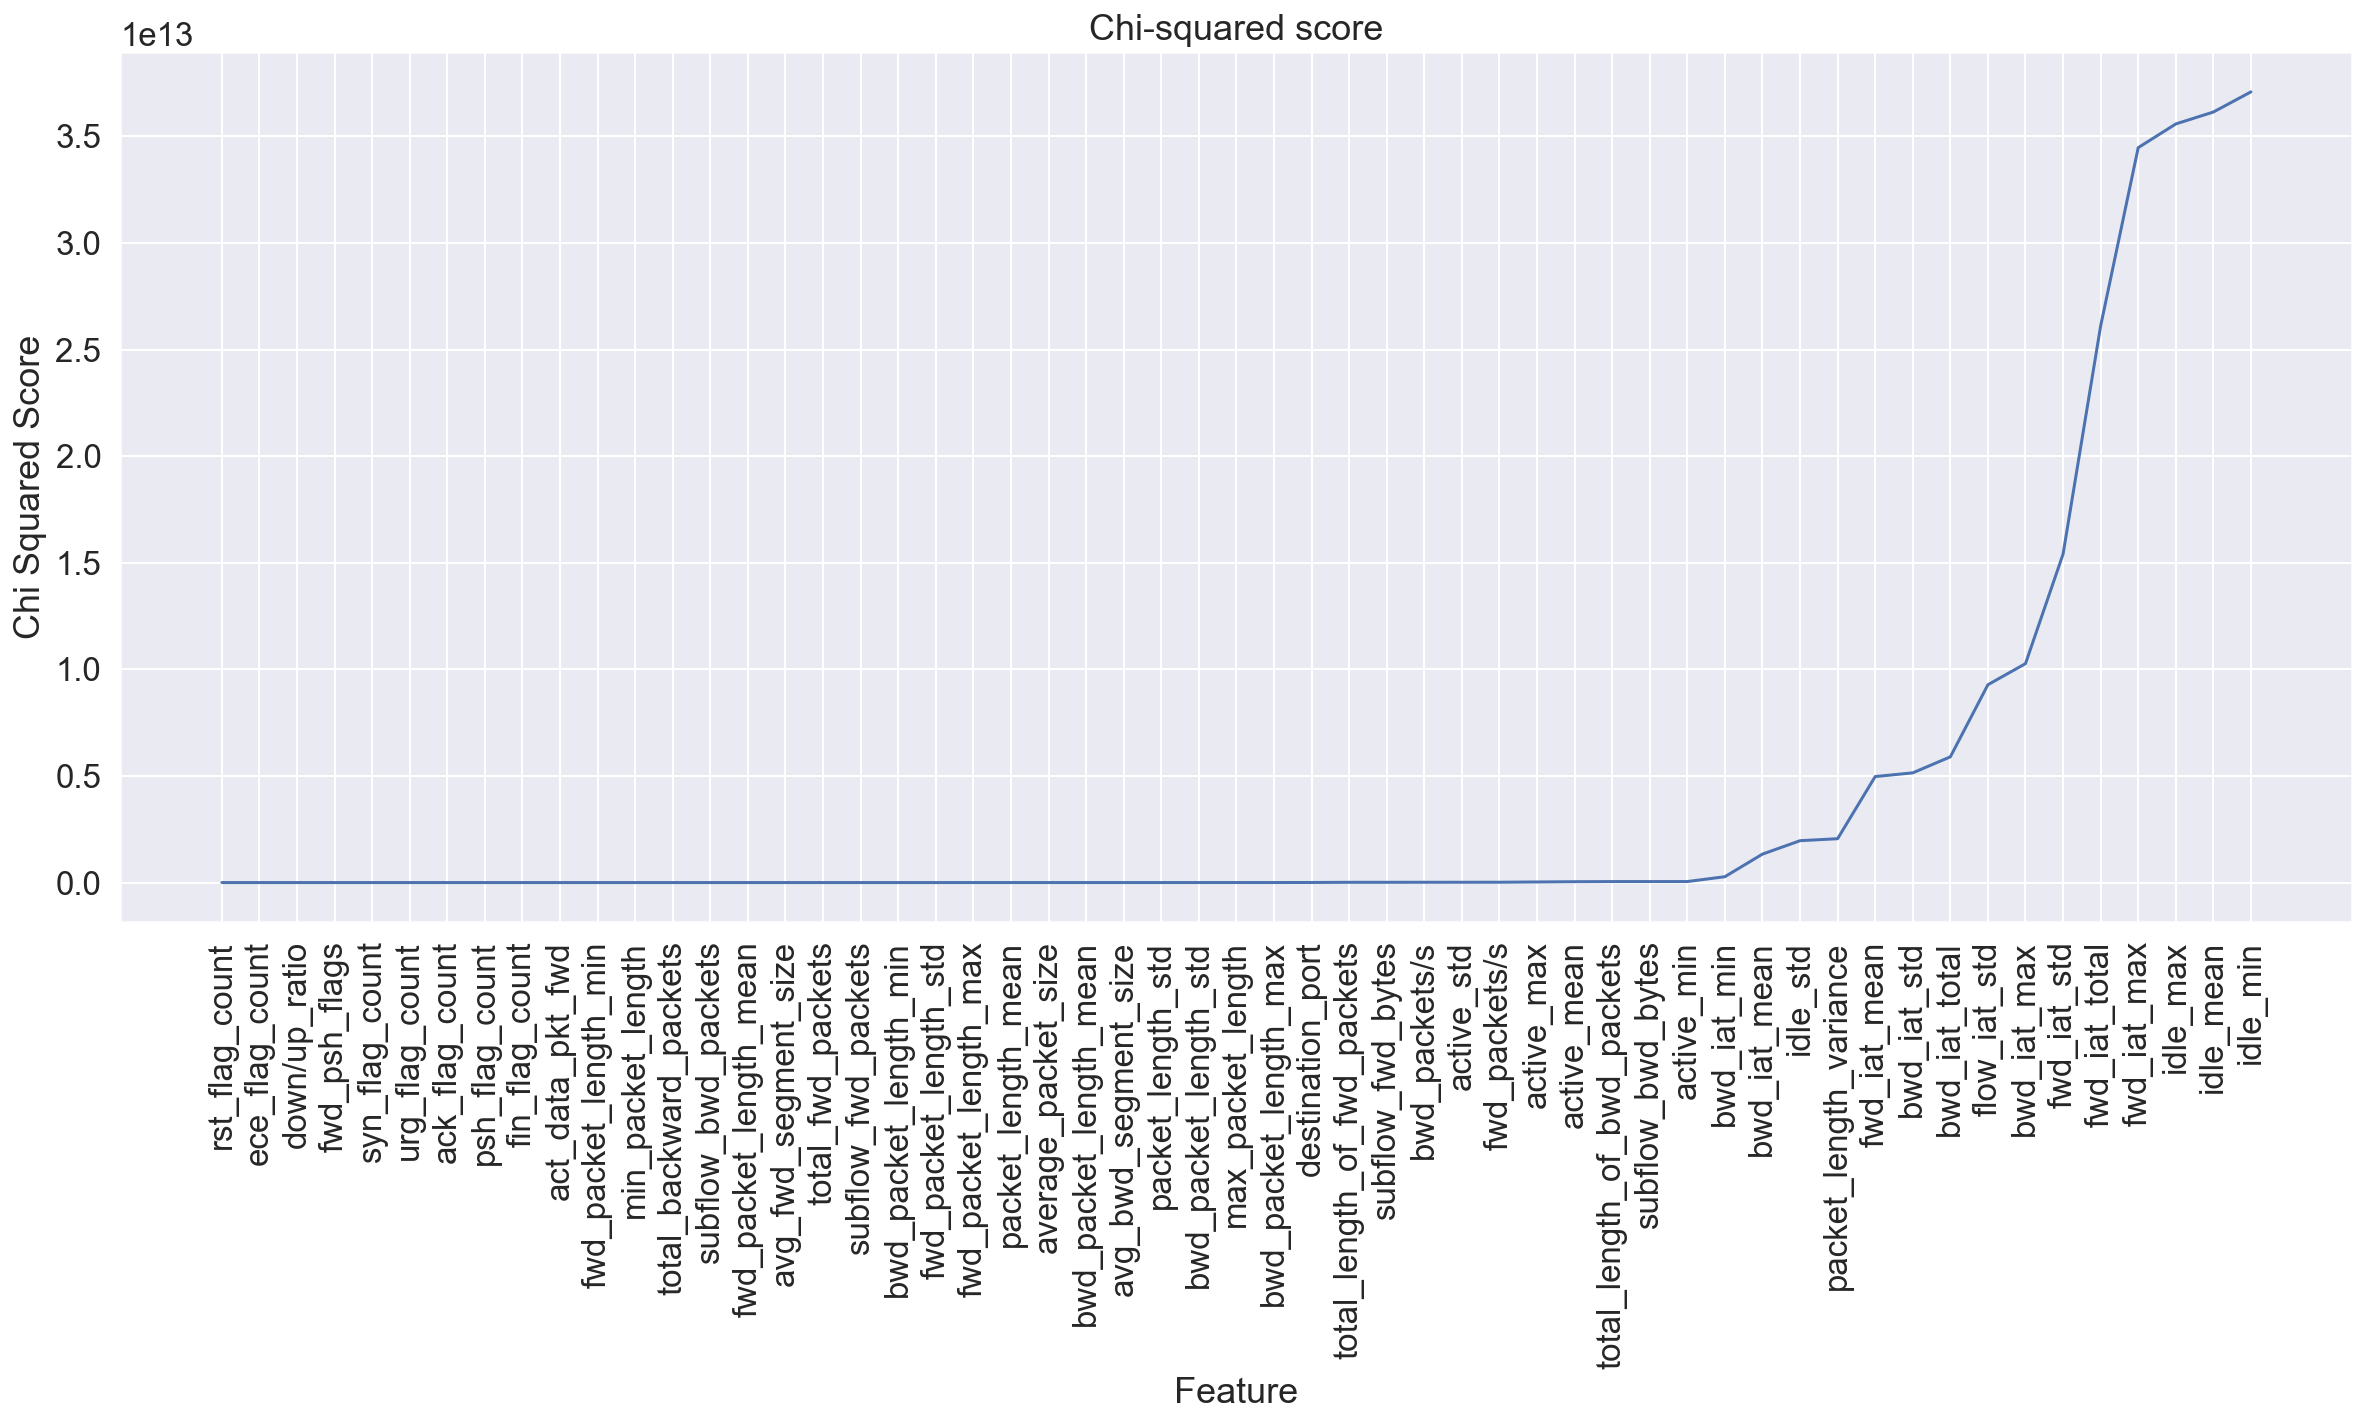

In [44]:
# Plot Chi-squared rsults.
plt.figure(figsize=(20, 8))
plt.plot([k for k in chi2_sortedlist], [chi2_sortedlist[k] for k in chi2_sortedlist])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Chi Squared Score')
plt.title('Chi-squared score')
plt.show();